In [ ]:
from google.colab import files
up = files.upload()  # select cross_venue_dislocations.zip from your computer
!unzip -o cross_venue_dislocations.zip -d .
%cd cross_venue_dislocations
!ls -la

Saving cross_venue_dislocations.zip to cross_venue_dislocations.zip
Archive:  cross_venue_dislocations.zip
   creating: ./cross_venue_dislocations/
  inflating: ./__MACOSX/._cross_venue_dislocations  
  inflating: ./cross_venue_dislocations/run_collect.py  
  inflating: ./__MACOSX/cross_venue_dislocations/._run_collect.py  
  inflating: ./cross_venue_dislocations/run_detect.py  
  inflating: ./__MACOSX/cross_venue_dislocations/._run_detect.py  
   creating: ./cross_venue_dislocations/core/
  inflating: ./__MACOSX/cross_venue_dislocations/._core  
  inflating: ./cross_venue_dislocations/requirements.txt  
  inflating: ./__MACOSX/cross_venue_dislocations/._requirements.txt  
  inflating: ./cross_venue_dislocations/config.yaml  
  inflating: ./__MACOSX/cross_venue_dislocations/._config.yaml  
  inflating: ./cross_venue_dislocations/README.md  
  inflating: ./__MACOSX/cross_venue_dislocations/._README.md  
   creating: ./cross_venue_dislocations/venues/
  inflating: ./__MACOSX/cross_venue_

In [ ]:
#install dependencies
!python -V
!pip install -r requirements.txt --quiet

Python 3.12.12


In [ ]:
# stop any old one (safe if none)
!pkill -f run_collect.py || true

# start and log output to a file
!nohup python -u run_collect.py > data/collector.out 2>&1 & echo "collector started"

^C
collector started


In [ ]:
!python run_detect.py
!python run_backtest.py

               spread_bps    max_mid     min_mid         z
ts_ms                                                     
1761704233207    3.125472  112514.15  112478.995  1.470498
1761704233216    3.125472  112514.15  112478.995  1.446496
1761704233459    3.125472  112514.15  112478.995  1.423335
1761704233476    3.125472  112514.15  112478.995  1.400980
1761704233482    3.125472  112514.15  112478.995  1.381985
Threshold (bps): 12.0
No events to backtest yet. Collect more data.


In [ ]:
import yaml
cfg = yaml.safe_load(open("config.yaml"))
# example: lower costs and persistence for more events
cfg["costs_bps"].update({"fee_bps":2,"half_spread_bps":1,"slippage_bps":3})
cfg["persistence_ms"] = 300
yaml.dump(cfg, open("config.yaml","w"), sort_keys=False)
print("Threshold (bps):", cfg["costs_bps"]["fee_bps"]+cfg["costs_bps"]["half_spread_bps"]+cfg["costs_bps"]["slippage_bps"]+cfg["costs_bps"].get("extra_bps",0))

Threshold (bps): 6


In [ ]:
!python run_detect.py
!python run_backtest.py

               spread_bps    max_mid     min_mid         z
ts_ms                                                     
1761704420446    0.260054  112479.65  112476.725 -0.857107
1761704420496    0.260054  112479.65  112476.725 -0.849961
1761704420654    0.260054  112479.65  112476.725 -0.842879
1761704420698    0.260054  112479.65  112476.725 -0.835860
1761704420731    0.260054  112479.65  112476.725 -0.828903
        start_ms         end_ms  duration_ms
0  1761704359430  1761704363433         4003
Threshold (bps): 6.0
   n_trades  hit_rate_%  avg_pnl_bps  sum_pnl_bps
0         1       100.0     0.231631     0.231631
         open_ms        exec_ms       close_ms   pnl_bps       pnl
0  1761704359430  1761704359950  1761704363433  0.231631  0.000023


In [ ]:
# CSV of all ticks (appendix)
import sqlite3, pandas as pd
conn = sqlite3.connect('data/dislocations.sqlite3')
pd.read_sql_query('select * from ticks order by ts_ms', conn).to_csv('data/ticks_export.csv', index=False)
conn.close()

Saved: figure_spread_timeseries.png, figure_spread_hist.png


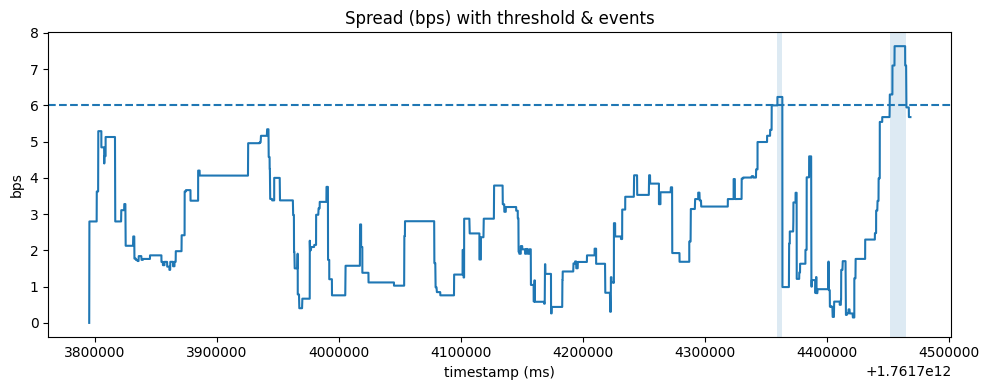

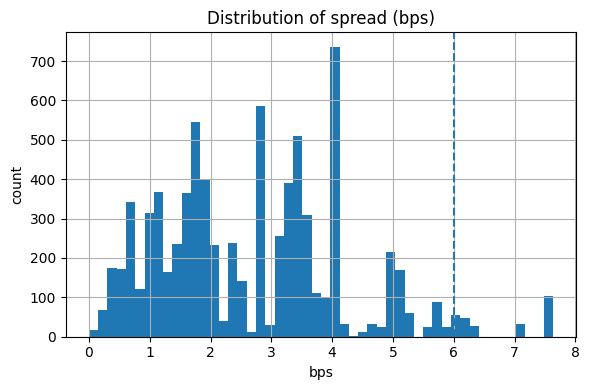

In [ ]:
# Figures: time series with event shading + histogram
import matplotlib.pyplot as plt
from core.detector import run_detection
res = run_detection(lookback_ms=60*60*1000)
m, e, thr = res['metrics'], res['events'], res['threshold_bps']

plt.figure(figsize=(10,4)); m['spread_bps'].plot(); plt.axhline(thr, ls='--')
for _, r in e.iterrows(): plt.axvspan(r['start_ms'], r['end_ms'], alpha=0.15)
plt.title("Spread (bps) with threshold & events"); plt.xlabel("timestamp (ms)"); plt.ylabel("bps")
plt.tight_layout(); plt.savefig("figure_spread_timeseries.png", dpi=300)

plt.figure(figsize=(6,4)); m['spread_bps'].dropna().hist(bins=50); plt.axvline(thr, ls='--')
plt.title("Distribution of spread (bps)"); plt.xlabel("bps"); plt.ylabel("count")
plt.tight_layout(); plt.savefig("figure_spread_hist.png", dpi=300)

print("Saved: figure_spread_timeseries.png, figure_spread_hist.png")

In [ ]:
from google.colab import files
for fn in ["data/dislocations.sqlite3","data/ticks_export.csv",
           "figure_spread_timeseries.png","figure_spread_hist.png"]:
    try: files.download(fn)
    except: pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import os, sqlite3, pandas as pd, yaml

cfg = yaml.safe_load(open("config.yaml"))
db = cfg.get("db_path", "data/dislocations.sqlite3")
print("DB path:", db, "| exists:", os.path.exists(db))

if os.path.exists(db):
    conn = sqlite3.connect(db)
    # how many ticks total?
    print(pd.read_sql_query("SELECT COUNT(*) AS rows FROM ticks", conn))
    # show a few recent rows
    display(pd.read_sql_query("SELECT * FROM ticks ORDER BY ts_ms DESC LIMIT 10", conn))
    conn.close()

DB path: data/dislocations.sqlite3 | exists: True
    rows
0  42800


,ts_ms,venue,bid,ask,mid
0,1761707400226,KRAKEN,112439.80,112439.90,112439.850
1,1761707400212,BITSTAMP,112488.00,112489.00,112488.500
2,1761707400143,COINBASE,112478.61,112478.62,112478.615
3,1761707399898,COINBASE,112474.00,112474.01,112474.005
4,1761707399882,KRAKEN,112439.80,112439.90,112439.850
5,1761707399868,BITSTAMP,112488.00,112489.00,112488.500
6,1761707399637,KRAKEN,112439.80,112439.90,112439.850
7,1761707399634,COINBASE,112474.00,112474.01,112474.005
8,1761707399616,BITSTAMP,112488.00,112489.00,112488.500
9,1761707399393,KRAKEN,112439.80,112439.90,112439.850


In [ ]:
import sqlite3, pandas as pd
conn = sqlite3.connect("data/dislocations.sqlite3")

# per-venue latest quotes
q1 = """
WITH latest AS (
  SELECT venue, MAX(ts_ms) AS ts
  FROM ticks GROUP BY venue
)
SELECT t.venue, t.ts_ms, t.bid, t.ask, t.mid
FROM ticks t JOIN latest l
  ON t.venue = l.venue AND t.ts_ms = l.ts
ORDER BY t.venue;
"""
display(pd.read_sql_query(q1, conn))

# basic time window stats (last 60 minutes)
q2 = """
SELECT
  MIN(ts_ms) AS start_ms,
  MAX(ts_ms) AS end_ms,
  COUNT(*)  AS n_ticks
FROM ticks
WHERE ts_ms >= (SELECT MAX(ts_ms) - 60*60*1000 FROM ticks);
"""
display(pd.read_sql_query(q2, conn))

conn.close()

,venue,ts_ms,bid,ask,mid
0,BITSTAMP,1761707421669,112521.00,112522.00,112521.500
1,COINBASE,1761707421488,112508.72,112508.73,112508.725
2,KRAKEN,1761707421472,112496.40,112496.50,112496.450


,start_ms,end_ms,n_ticks
0,1761703821889,1761707421746,42758


In [ ]:
import sqlite3, pandas as pd
conn = sqlite3.connect("data/dislocations.sqlite3")
pd.read_sql_query("SELECT * FROM ticks ORDER BY ts_ms", conn).to_csv("data/ticks_export.csv", index=False)
conn.close()
print("Saved: data/ticks_export.csv")


Saved: data/ticks_export.csv


In [ ]:
from core.detector import run_detection
import pandas as pd

res = run_detection(lookback_ms=60*60*1000)  # last 60 min
events = res['events'].copy()
if not events.empty:
    # keep the most informative columns
    keep = ["start_ms","end_ms","duration_ms","max_mid","min_mid","spread_bps"]
    events[keep].to_csv("data/events_last60min.csv", index=False)
    display(events[keep].head(8))
    print("Saved: data/events_last60min.csv")
else:
    print("No events in the last 60 minutes.")

KeyError: "['max_mid', 'min_mid', 'spread_bps'] not in index"

In [ ]:
import numpy as np, pandas as pd
from core.detector import run_detection

# Analyze last 60 minutes (change if you want)
LOOKBACK_MS = 60*60*1000
res = run_detection(lookback_ms=LOOKBACK_MS)

m  = res['metrics']          # time series with 'spread_bps'
ev = res['events'].copy()    # events table
thr = res['threshold_bps']

print("Available event columns:", ev.columns.tolist())

if ev.empty:
    print("No events in the last 60 minutes.")
else:
    # If 'peak_bps' not provided, compute it from the metrics segment
    if 'peak_bps' not in ev.columns:
        # ensure metrics uses a numeric index of timestamps
        ts = m.index if isinstance(m.index, pd.Index) else pd.Index(m.index)
        def peak_bps(row):
            seg = m[(ts >= row['start_ms']) & (ts <= row['end_ms'])]
            return float(seg['spread_bps'].max()) if not seg.empty else np.nan
        ev['peak_bps'] = ev.apply(peak_bps, axis=1)

    # Pick columns that actually exist
    preferred = ["start_ms","end_ms","duration_ms","peak_bps","max_mid","min_mid"]
    keep = [c for c in preferred if c in ev.columns]

    # Save a compact table
    out = ev[keep].sort_values("start_ms")
    display(out.head(10))
    out.to_csv("data/events_last60min.csv", index=False)
    print("Saved: data/events_last60min.csv")


Available event columns: ['start_ms', 'end_ms', 'duration_ms']


,start_ms,end_ms,duration_ms,peak_bps
0,1761704359430,1761704363433,4003,6.231631
1,1761704451404,1761704464852,13448,7.632492
2,1761704481099,1761704489292,8193,7.365777
3,1761704620731,1761704624960,4229,6.704876
4,1761704870939,1761704876949,6010,11.041639
5,1761705000157,1761705023979,23822,10.709839
6,1761705030515,1761705048056,17541,9.099137
7,1761706159565,1761706182163,22598,8.426555
8,1761706230536,1761706265981,35445,8.280872
9,1761706571091,1761706581116,10025,6.654444


Saved: data/events_last60min.csv


In [ ]:
from google.colab import files
files.download("data/events_last60min.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd, datetime as dt
ev = pd.read_csv("data/events_last60min.csv")
def to_utc(ms):
    return dt.datetime.utcfromtimestamp(ms/1000).strftime("%Y-%m-%d %H:%M:%S")
if "start_ms" in ev and "end_ms" in ev:
    ev["start_utc"] = ev["start_ms"].apply(to_utc)
    ev["end_utc"]   = ev["end_ms"].apply(to_utc)
    if "duration_ms" in ev:
        ev["duration_s"] = (ev["duration_ms"]/1000).round(2)
cols = [c for c in ["start_utc","end_utc","duration_s","peak_bps"] if c in ev.columns]
pretty = ev[cols].head(8)  # top 8 rows for the poster
pretty.to_csv("data/events_pretty.csv", index=False)
pretty

/tmp/ipython-input-418411517.py:4: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  return dt.datetime.utcfromtimestamp(ms/1000).strftime("%Y-%m-%d %H:%M:%S")
/tmp/ipython-input-418411517.py:4: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  return dt.datetime.utcfromtimestamp(ms/1000).strftime("%Y-%m-%d %H:%M:%S")


,start_utc,end_utc,duration_s,peak_bps
0,2025-10-29 02:19:19,2025-10-29 02:19:23,4.00,6.231631
1,2025-10-29 02:20:51,2025-10-29 02:21:04,13.45,7.632492
2,2025-10-29 02:21:21,2025-10-29 02:21:29,8.19,7.365777
3,2025-10-29 02:23:40,2025-10-29 02:23:44,4.23,6.704876
4,2025-10-29 02:27:50,2025-10-29 02:27:56,6.01,11.041639
5,2025-10-29 02:30:00,2025-10-29 02:30:23,23.82,10.709839
6,2025-10-29 02:30:30,2025-10-29 02:30:48,17.54,9.099137
7,2025-10-29 02:49:19,2025-10-29 02:49:42,22.60,8.426555


In [ ]:
from google.colab import files
files.download("data/events_pretty.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
for fn in ["results_box.png","results_box.txt","results_box.json"]:
    try: files.download(fn)
    except: pass

In [ ]:
from google.colab import files
for fn in [
    "data/events_pretty.csv",        # readable event table (UTC, duration, peak_bps)
    "data/events_last60min.csv",     # raw event slice
    "results_box.png", "results_box.txt", "results_box.json",
    "figure_spread_timeseries.png", "figure_spread_hist.png",
    "data/ticks_export.csv",         # full tick dump (if you created it)
    "data/dislocations.sqlite3"      # the SQLite database
]:
    try:
        files.download(fn)
    except Exception as e:
        print("Skip:", fn, "-", e)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Skip: results_box.png - Cannot find file: results_box.png
Skip: results_box.txt - Cannot find file: results_box.txt
Skip: results_box.json - Cannot find file: results_box.json


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!mkdir -p "/content/drive/MyDrive/cvd_results"
!cp -f data/dislocations.sqlite3 data/events_pretty.csv data/events_last60min.csv \
      figure_spread_timeseries.png figure_spread_hist.png results_box.png \
      "/content/drive/MyDrive/cvd_results/" 2>/dev/null || true
!ls -la "/content/drive/MyDrive/cvd_results"


Mounted at /content/drive
total 4302
-rw------- 1 root root 4198400 Oct 29 03:17 dislocations.sqlite3
-rw------- 1 root root    1228 Oct 29 03:17 events_last60min.csv
-rw------- 1 root root     543 Oct 29 03:17 events_pretty.csv
-rw------- 1 root root   66754 Oct 29 03:17 figure_spread_hist.png
-rw------- 1 root root  136767 Oct 29 03:17 figure_spread_timeseries.png


In [ ]:
!pkill -f run_collect.py
